In [1]:
# Loading the Libraries
import pandas as pd
from ores import api
import matplotlib.pyplot as plt

In [2]:
# Loading the data files
page_data = pd.read_csv("page_data.csv")
WPDS_data = pd.read_csv("WPDS_2018_data.csv")

## Cleaning the data
- In the case of page_data.csv, the dataset contains some page names that start with the string "Template:". These pages are not Wikipedia articles, and should not be included in analysis.
- WPDS_2018_data contains some rows that provide cumulative regional population counts, rather than country-level counts. These rows are distinguished by having ALL CAPS values in the 'geography' field (e.g. AFRICA, OCEANIA). These rows won't match the country values in page_data, but you will want to retain them (either in the original file, or a separate file) so that you can report coverage and quality by region in the analysis section.

In [3]:
# Removing the "template"
page_data_clean = page_data[~page_data.page.str.contains("Template")]

In [4]:
print( "After Data Cleaning page_data: ")
print ("Rows     : " ,page_data_clean.shape[0])
print ("Columns  : " ,page_data_clean.shape[1])
print ("\nFeatures : \n" ,page_data_clean.columns.tolist())
print ("\nMissing values :  ", page_data_clean.isnull().sum().values.sum())
print ("\nUnique values :  \n",page_data_clean.nunique())

After Data Cleaning page_data: 
Rows     :  46701
Columns  :  3

Features : 
 ['page', 'country', 'rev_id']

Missing values :   0

Unique values :  
 page       46701
country      219
rev_id     46701
dtype: int64


In [5]:
#Changing column names
WPDS_data = WPDS_data.rename(columns={"Geography": "country"})

In [6]:
# Loading the seperate WPDS file with a new region column which can be accessed as needed
WPDS_new = pd.read_csv("WPDS_2018_seperate_data.csv")

## Getting article quality predictions
- Predicted quality scores for each article in the Wikipedia dataset. We're using a machine learning system called ORES ("Objective Revision Evaluation Service"). ORES estimates the quality of an article (at a particular point in time), and assigns a series of probabilities that the article is in one of 6 quality categories.

In [7]:
# Getting the revision IDs
rev_ids = page_data_clean.rev_id.tolist()

In [8]:
# pip install ores in your local notebook environment
# Send all ~50k articles in the page_data.csv in a single batch 

ores_session = api.Session("https://ores.wikimedia.org", "Class project <jmorgan@wikimedia.org>")
results = ores_session.score("enwiki", ["articlequality"], rev_ids)
probDF = pd.DataFrame()
probList = []
for prediction, rev_id in zip(results, rev_ids):
        if list(prediction['articlequality'].keys()) != ['error']:
            temp = pd.DataFrame(prediction['articlequality']['score'])
            #print(str(rev_id) + " " + str(temp['prediction'][0]))
            probList.append([rev_id, temp['prediction'][0]])

# Get data in a dataframe            
probDF = pd.DataFrame(probList)  

In [10]:
# Dataframe with the predictions
probDF = probDF.rename(columns={1: "article_quality", 0: "rev_id"})

## Combining the datasets
- After retrieving and including the ORES data for each article - merge the wikipedia data and population data together. Both have fields containing country names for just that purpose. 
- After merging the data, you'll invariably run into entries which cannot be merged. Either the population dataset does not have an entry for the equivalent Wikipedia country, or vis versa.
- Any rows that do not have matching data, and output them to a CSV file called wp_wpds_countries-no_match.csv
- The remaining data into a single CSV file called wp_wpds_politicians_by_country.csv

In [12]:
# Combining the probability from probDF with page_data 
new_page_data = pd.merge(probDF , page_data_clean, how='left', on=['rev_id'])
# Combining WPDS data with the data above
combined_data = pd.merge(new_page_data , WPDS_data, how='left', on=['country'])
combined_data = combined_data.dropna()

In [13]:
# Data we could not find probability for (they did not have a match)
def anti_join(x, y, on):
    """
    Anti-join of two data frames. Return rows in x which are not present in y
    """
    ans = pd.merge(left=x, right=y, how='left', indicator=True, on=on)
    ans = ans.loc[ans._merge == 'left_only', :].drop(columns='_merge')
    return ans

# Dataframe with no results
no_class = anti_join(WPDS_data, combined_data, ['country'])
no_class = no_class.drop(["rev_id", "article_quality", "page", "Population mid-2018 (millions)_x", "Population mid-2018 (millions)_y"], 1)
# Saving these to a CSV file
no_class.to_csv('wp_wpds_countries-no_match.csv')

In [14]:
# Getting the right format
combined_data = combined_data.rename(columns={"rev_id": "revision_id"})
# Saving this to a csv
combined_data.to_csv('wp_wpds_politicians_by_country.csv')

## Analysis
- Analysis will consist of calculating the proportion (as a percentage) of articles-per-population and high-quality articles for each country AND for each geographic region. 
- By "high quality" articles, in this case we mean the number of articles about politicians in a given country that ORES predicted would be in either the "FA" (featured article) or "GA" (good article) classes.

### Analysis 1: articles-per-population 

In [15]:
combined_data_new = combined_data
# data frame gives us the frequency of the times a country had an article i.e the number of articles for a country
combined_data_new["frequency"] = combined_data_new.groupby('country')["country"].transform('count')
# Converting the population column to float value
combined_data_new["Population mid-2018 (millions)"] = combined_data_new["Population mid-2018 (millions)"].str.replace(',', '').astype(float)

In [16]:
# Finding the articles-per-population-percentage
combined_data_new["articles-per-population-percentage"] = ((combined_data_new["frequency"])/(combined_data_new["Population mid-2018 (millions)"]*1000000))*100


In [17]:
# Dropping rows from the table that we do not need
articles_population = combined_data_new.drop(["revision_id", "article_quality", "page", "frequency"], 1)
# Dropping Duplicates
articles_population = articles_population.drop_duplicates(subset=['country'], keep="first")
# Dataframe with the articles per population
articles_population = articles_population.sort_values('articles-per-population-percentage', ascending=False)

In [21]:
articles_population.head()

,country,Population mid-2018 (millions),articles-per-population-percentage
248,Tuvalu,0.01,0.54
1166,Nauru,0.01,0.52
87,San Marino,0.03,0.27
156,Monaco,0.04,0.10
246,Liechtenstein,0.04,0.07


### Analysis 2: high-quality articles
- By "high quality" articles, in this case we mean the number of articles about politicians in a given country that ORES predicted would be in either the "FA" (featured article) or "GA" (good article) classes.

In [22]:
def HQ(x):
    """
    Function to categorise 1 if the prediction is FA or GA, and 0 otherwise
    """
    if "Stub" in x:
        return 0
    elif "B" in x:
        return 0
    elif "C" in x:
        return 0
    elif "Start" in x:
        return 0
    else: return 1

# Categorising the data set
combined_data_new["GA_FA"] = combined_data_new["article_quality"].apply(HQ)
# Keeping only the required rows
high_quality = combined_data_new.drop(["revision_id", "article_quality", "page", "Population mid-2018 (millions)", "articles-per-population-percentage", "frequency"], 1)
# Removing articles which are not high quality
high_quality = high_quality[high_quality.GA_FA != 0]
# Dropping the column not needed
combined_data_new = combined_data_new.drop(["GA_FA"], 1)
# Grouping by country to find number of GA and FA per country
high_quality = high_quality.groupby(['country']).sum().reset_index()

In [23]:
# Combining this with the data we already have to get the frequency of articles for a country
GA_FA_data = pd.merge(high_quality , combined_data_new, how='left', on=['country'])
# Finding the percentage of high quality articles = (high quality articles/ total articles)*100
GA_FA_data["high-quality-percentage"] = ((GA_FA_data["GA_FA"])/(GA_FA_data["frequency"]))*100
# Dropping unnecessary columns and rows
GA_FA_data = GA_FA_data.drop(["GA_FA", "revision_id", "article_quality", "page", "articles-per-population-percentage", "frequency"], 1)
GA_FA_data = GA_FA_data.drop_duplicates(subset=['country'], keep="first")
# Sorting the data
GA_FA_data = GA_FA_data.sort_values('high-quality-percentage', ascending=False)

GA_FA_data.head()

,country,Population mid-2018 (millions),high-quality-percentage
20143,"Korea, North",25.6,19.444444
32509,Saudi Arabia,33.4,12.711864
22589,Mauritania,4.5,12.500000
7144,Central African Republic,4.7,12.121212
31185,Romania,19.5,11.370262


In [67]:
#Saving all data into csv
# Creating a file with all data combined
final_data = pd.merge(high_quality , combined_data_new, how='left', on=['country'])
# adding high_quality column
final_data["high-quality-percentage"] = ((final_data["GA_FA"])/(final_data["frequency"]))*100
final_data.to_csv("Final_combined_data.csv")

### Analysis based on Geographic regions


In [24]:
# Let us see what geographic regions we have
Geographic_Region = WPDS_data[WPDS_data['country'].str.isupper()]
Geographic_Region

,country,Population mid-2018 (millions)
0,AFRICA,"1,284"
56,NORTHERN AMERICA,365
59,LATIN AMERICA AND THE CARIBBEAN,649
95,ASIA,"4,536"
144,EUROPE,746
189,OCEANIA,41


In [25]:
# Finding indices at which these region names begin to disect data into regions
america_index = WPDS_data[WPDS_data['country']=="NORTHERN AMERICA"].index.values.astype(int)[0]
africa_index = WPDS_data[WPDS_data['country']=="AFRICA"].index.values.astype(int)[0]
latin_index = WPDS_data[WPDS_data['country']=="LATIN AMERICA AND THE CARIBBEAN"].index.values.astype(int)[0]
asia_index = WPDS_data[WPDS_data['country']=="ASIA"].index.values.astype(int)[0]
europe_index = WPDS_data[WPDS_data['country']=="EUROPE"].index.values.astype(int)[0]
oceania_index = WPDS_data[WPDS_data['country']=="OCEANIA"].index.values.astype(int)[0]

In [26]:
# Getting data for seperate regions
africa_WPDS_data = WPDS_data.iloc[(africa_index+1):america_index,:]
america_WPDS_data = WPDS_data.iloc[(america_index+1):latin_index,:]
latin_WPDS_data = WPDS_data.iloc[(latin_index+1):asia_index,:]
asia_WPDS_data = WPDS_data.iloc[(asia_index+1):europe_index,:]
europe_WPDS_data = WPDS_data.iloc[(europe_index+1):oceania_index,:]
oceania_WPDS_data = WPDS_data.iloc[(oceania_index+1):,:]

### Analysis 3: Geographic Region based articles per population

#### AFRICA

In [27]:
print("Number of countries in Africa:", africa_WPDS_data.shape[0])

Number of countries in Africa: 55


In [28]:
# Merging geographical data with total article numbers (frequency)
# to get the number of articles in each of these countries
africa_combined_data = pd.merge(africa_WPDS_data , combined_data_new, how='left', on=['country'])
#Removing columns not required and duplicate rows
africa_combined_data = africa_combined_data.drop(["Population mid-2018 (millions)_y","Population mid-2018 (millions)_x", "revision_id", "article_quality", "page", "articles-per-population-percentage"], 1)
africa_combined_data = africa_combined_data.drop_duplicates(subset=['country'], keep="first")

# frequency = total number of articles in the country as described above.
# We take sum of articles publisdhed by all countries in that geography
africa_frequency = africa_combined_data['frequency'].sum()
print("Total number of articles published in Africa", africa_frequency)

Total number of articles published in Africa 6851.0


#### NORTHERN AMERICA

In [29]:
print("Number of countries in Northern America:", america_WPDS_data.shape[0])

Number of countries in Northern America: 2


In [30]:
# Merging geographical data with total article numbers (frequency)
# to get the number of articles in each of these countries
america_combined_data = pd.merge(america_WPDS_data , combined_data_new, how='left', on=['country'])
#Removing columns not required and duplicate rows
america_combined_data = america_combined_data.drop(["Population mid-2018 (millions)_y","Population mid-2018 (millions)_x", "revision_id", "article_quality", "page", "articles-per-population-percentage"], 1)
america_combined_data = america_combined_data.drop_duplicates(subset=['country'], keep="first")

# frequency = total number of articles in the country as described above.
# We take sum of articles publisdhed by all countries in that geography
america_frequency = america_combined_data['frequency'].sum()
print("Total number of articles published in america", america_frequency)

Total number of articles published in america 1921


#### LATIN AMERICA AND THE CARIBBEAN

In [31]:
print("Number of countries in LATIN AMERICA AND THE CARIBBEAN:", latin_WPDS_data.shape[0])

Number of countries in LATIN AMERICA AND THE CARIBBEAN: 35


In [32]:
# Merging geographical data with total article numbers (frequency)
# to get the number of articles in each of these countries
latin_combined_data = pd.merge(latin_WPDS_data , combined_data_new, how='left', on=['country'])
#Removing columns not required and duplicate rows
latin_combined_data = latin_combined_data.drop(["Population mid-2018 (millions)_y","Population mid-2018 (millions)_x", "revision_id", "article_quality", "page", "articles-per-population-percentage"], 1)
latin_combined_data = latin_combined_data.drop_duplicates(subset=['country'], keep="first")

# frequency = total number of articles in the country as described above.
# We take sum of articles publisdhed by all countries in that geography
latin_frequency = latin_combined_data['frequency'].sum()
print("Total number of articles published in latin", latin_frequency)

Total number of articles published in latin 5169.0


#### ASIA

In [33]:
print("Number of countries in ASIA:", asia_WPDS_data.shape[0])

Number of countries in ASIA: 48


In [34]:
# Merging geographical data with total article numbers (frequency)
# to get the number of articles in each of these countries
asia_combined_data = pd.merge(asia_WPDS_data , combined_data_new, how='left', on=['country'])
#Removing columns not required and duplicate rows
asia_combined_data = asia_combined_data.drop(["Population mid-2018 (millions)_y","Population mid-2018 (millions)_x", "revision_id", "article_quality", "page", "articles-per-population-percentage"], 1)
asia_combined_data = asia_combined_data.drop_duplicates(subset=['country'], keep="first")

# frequency = total number of articles in the country as described above.
# We take sum of articles publisdhed by all countries in that geography
asia_frequency = asia_combined_data['frequency'].sum()
print("Total number of articles published in asia", asia_frequency)

Total number of articles published in asia 11531.0


#### EUROPE

In [35]:
print("Number of countries in Europe:", europe_WPDS_data.shape[0])

Number of countries in Europe: 44


In [36]:
# Merging geographical data with total article numbers (frequency)
# to get the number of articles in each of these countries
europe_combined_data = pd.merge(europe_WPDS_data , combined_data_new, how='left', on=['country'])
#Removing columns not required and duplicate rows
europe_combined_data = europe_combined_data.drop(["Population mid-2018 (millions)_y","Population mid-2018 (millions)_x", "revision_id", "article_quality", "page", "articles-per-population-percentage"], 1)
europe_combined_data = europe_combined_data.drop_duplicates(subset=['country'], keep="first")

# frequency = total number of articles in the country as described above.
# We take sum of articles publisdhed by all countries in that geography
europe_frequency = europe_combined_data['frequency'].sum()
print("Total number of articles published in europe", europe_frequency)

Total number of articles published in europe 15864.0


#### OCEANIA

In [37]:
print("Number of countries in Oceania:", oceania_WPDS_data.shape[0])

Number of countries in Oceania: 17


In [38]:
# Merging geographical data with total article numbers (frequency)
# to get the number of articles in each of these countries
oceania_combined_data = pd.merge(oceania_WPDS_data , combined_data_new, how='left', on=['country'])
#Removing columns not required and duplicate rows
oceania_combined_data = oceania_combined_data.drop(["Population mid-2018 (millions)_y","Population mid-2018 (millions)_x", "revision_id", "article_quality", "page", "articles-per-population-percentage"], 1)
oceania_combined_data = oceania_combined_data.drop_duplicates(subset=['country'], keep="first")

# frequency = total number of articles in the country as described above.
# We take sum of articles publisdhed by all countries in that geography
oceania_frequency = oceania_combined_data['frequency'].sum()
print("Total number of articles published in oceania", oceania_frequency)

Total number of articles published in oceania 3128.0


#### Getting the dataframe together

In [39]:
# Adding the article frequency per country
Geographic_Region["frequency"] = [africa_frequency,america_frequency,latin_frequency,asia_frequency,europe_frequency, oceania_frequency]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
# Converting the population column to float value
Geographic_Region["Population mid-2018 (millions)"] = Geographic_Region["Population mid-2018 (millions)"].str.replace(',', '').astype(float)
# Calculating the articles by population percentage
Geographic_Region["articles-per-population-percentage"] = ((Geographic_Region["frequency"])/(Geographic_Region["Population mid-2018 (millions)"]*1000000))*100



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Analysis 4: Geographical region high quality article analysis

#### Africa

In [41]:
# merging geography specific data with the data frame "high_quality" to get the frequency of FA and GA articles
africa_quality_data = pd.merge(africa_WPDS_data , high_quality, how='left', on=['country'])

# merging this data with the dataframe to get the frequency or number of articles published by each country
africa_quality_data = pd.merge(africa_quality_data , combined_data_new, how='left', on=['country'])

# removing unwanted rows and columns
africa_quality_data = africa_quality_data.drop(["Population mid-2018 (millions)_y","Population mid-2018 (millions)_x", "revision_id", "article_quality", "page", "articles-per-population-percentage"], 1)
africa_quality_data = africa_quality_data.drop_duplicates(subset=['country'], keep="first")

# Total FA and GA articles in all geography specific countries
africa_FA_GA = africa_quality_data['GA_FA'].sum()

# Total articles in all geography specific countries
africa_frequency = africa_quality_data['frequency'].sum()

# The percentage of high quality articles in the geography
africa_high_quality = (africa_FA_GA/africa_frequency)*100

print("FA GA article percentage:", africa_high_quality)

FA GA article percentage: 1.824551160414538


#### Northern America

In [42]:
# merging geography specific data with the data frame "high_quality" to get the frequency of FA and GA articles
america_quality_data = pd.merge(america_WPDS_data , high_quality, how='left', on=['country'])

# merging this data with the dataframe to get the frequency or number of articles published by each country
america_quality_data = pd.merge(america_quality_data , combined_data_new, how='left', on=['country'])

# removing unwanted rows and columns
america_quality_data = america_quality_data.drop(["Population mid-2018 (millions)_y","Population mid-2018 (millions)_x", "revision_id", "article_quality", "page", "articles-per-population-percentage"], 1)
america_quality_data = america_quality_data.drop_duplicates(subset=['country'], keep="first")

# Total FA and GA articles in all geography specific countries
america_FA_GA = america_quality_data['GA_FA'].sum()

# Total articles in all geography specific countries
america_frequency = america_quality_data['frequency'].sum()

# The percentage of high quality articles in the geography
america_high_quality = (america_FA_GA/america_frequency)*100

print("FA GA article percentage:", america_high_quality)

FA GA article percentage: 5.153565851119208


#### Latin America and Caribbean islands 

In [43]:
# merging geography specific data with the data frame "high_quality" to get the frequency of FA and GA articles
latin_quality_data = pd.merge(latin_WPDS_data , high_quality, how='left', on=['country'])

# merging this data with the dataframe to get the frequency or number of articles published by each country
latin_quality_data = pd.merge(latin_quality_data , combined_data_new, how='left', on=['country'])

# removing unwanted rows and columns
latin_quality_data = latin_quality_data.drop(["Population mid-2018 (millions)_y","Population mid-2018 (millions)_x", "revision_id", "article_quality", "page", "articles-per-population-percentage"], 1)
latin_quality_data = latin_quality_data.drop_duplicates(subset=['country'], keep="first")

# Total FA and GA articles in all geography specific countries
latin_FA_GA = latin_quality_data['GA_FA'].sum()

# Total articles in all geography specific countries
latin_frequency = latin_quality_data['frequency'].sum()

# The percentage of high quality articles in the geography
latin_high_quality = (latin_FA_GA/latin_frequency)*100

print("FA GA article percentage:", latin_high_quality)

FA GA article percentage: 1.3348810214741729


#### Asia

In [44]:
# merging geography specific data with the data frame "high_quality" to get the frequency of FA and GA articles
asia_quality_data = pd.merge(asia_WPDS_data , high_quality, how='left', on=['country'])

# merging this data with the dataframe to get the frequency or number of articles published by each country
asia_quality_data = pd.merge(asia_quality_data , combined_data_new, how='left', on=['country'])

# removing unwanted rows and columns
asia_quality_data = asia_quality_data.drop(["Population mid-2018 (millions)_y","Population mid-2018 (millions)_x", "revision_id", "article_quality", "page", "articles-per-population-percentage"], 1)
asia_quality_data = asia_quality_data.drop_duplicates(subset=['country'], keep="first")

# Total FA and GA articles in all geography specific countries
asia_FA_GA = asia_quality_data['GA_FA'].sum()

# Total articles in all geography specific countries
asia_frequency = asia_quality_data['frequency'].sum()

# The percentage of high quality articles in the geography
asia_high_quality = (asia_FA_GA/asia_frequency)*100

print("FA GA article percentage:", asia_high_quality)

FA GA article percentage: 2.688405168675744


#### Europe

In [45]:
# merging geography specific data with the data frame "high_quality" to get the frequency of FA and GA articles
europe_quality_data = pd.merge(europe_WPDS_data , high_quality, how='left', on=['country'])

# merging this data with the dataframe to get the frequency or number of articles published by each country
europe_quality_data = pd.merge(europe_quality_data , combined_data_new, how='left', on=['country'])

# removing unwanted rows and columns
europe_quality_data = europe_quality_data.drop(["Population mid-2018 (millions)_y","Population mid-2018 (millions)_x", "revision_id", "article_quality", "page", "articles-per-population-percentage"], 1)
europe_quality_data = europe_quality_data.drop_duplicates(subset=['country'], keep="first")

# Total FA and GA articles in all geography specific countries
europe_FA_GA = europe_quality_data['GA_FA'].sum()

# Total articles in all geography specific countries
europe_frequency = europe_quality_data['frequency'].sum()

# The percentage of high quality articles in the geography
europe_high_quality = (europe_FA_GA/europe_frequency)*100

print("FA GA article percentage:", europe_high_quality)

FA GA article percentage: 2.0297528996469993


#### Oceania

In [46]:
# merging geography specific data with the data frame "high_quality" to get the frequency of FA and GA articles
oceania_quality_data = pd.merge(oceania_WPDS_data , high_quality, how='left', on=['country'])

# merging this data with the dataframe to get the frequency or number of articles published by each country
oceania_quality_data = pd.merge(oceania_quality_data , combined_data_new, how='left', on=['country'])

# removing unwanted rows and columns
oceania_quality_data = oceania_quality_data.drop(["Population mid-2018 (millions)_y","Population mid-2018 (millions)_x", "revision_id", "article_quality", "page", "articles-per-population-percentage"], 1)
oceania_quality_data = oceania_quality_data.drop_duplicates(subset=['country'], keep="first")

# Total FA and GA articles in all geography specific countries
oceania_FA_GA = oceania_quality_data['GA_FA'].sum()

# Total articles in all geography specific countries
oceania_frequency = oceania_quality_data['frequency'].sum()

# The percentage of high quality articles in the geography
oceania_high_quality = (oceania_FA_GA/oceania_frequency)*100

print("FA GA article percentage:", oceania_high_quality)

FA GA article percentage: 2.1099744245524295


#### Merging Results to a dataframe

In [47]:
Geographic_Region["FA_GA_total"] = [africa_high_quality, america_high_quality, latin_high_quality, asia_high_quality, europe_high_quality, oceania_high_quality]
# Calculating high quality article percentage
Geographic_Region["high-quality-percentage"] = ((Geographic_Region["FA_GA_total"])/(Geographic_Region["frequency"]))*100
Geographic_Region = Geographic_Region.drop(["frequency", "FA_GA_total"], 1)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Results

### Table 1: Top 10 countries by coverage: 10 highest-ranked countries in terms of number of politician articles as a proportion of country population

In [48]:
top_10_art_per_pop = articles_population.head(10)

In [49]:
top_10_art_per_pop

,country,Population mid-2018 (millions),articles-per-population-percentage
248,Tuvalu,0.01,0.540000
1166,Nauru,0.01,0.520000
87,San Marino,0.03,0.270000
156,Monaco,0.04,0.100000
246,Liechtenstein,0.04,0.070000
211,Tonga,0.10,0.063000
275,Marshall Islands,0.06,0.061667
164,Iceland,0.40,0.050250
2961,Andorra,0.08,0.042500
189,Grenada,0.10,0.036000


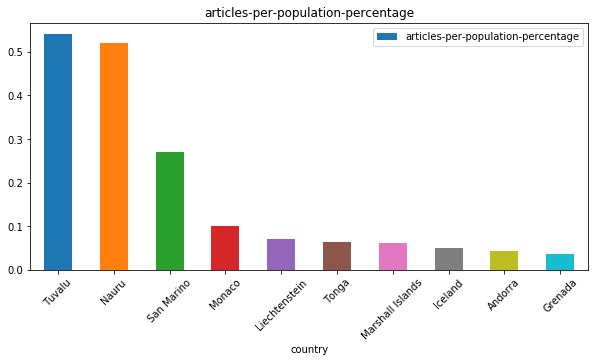

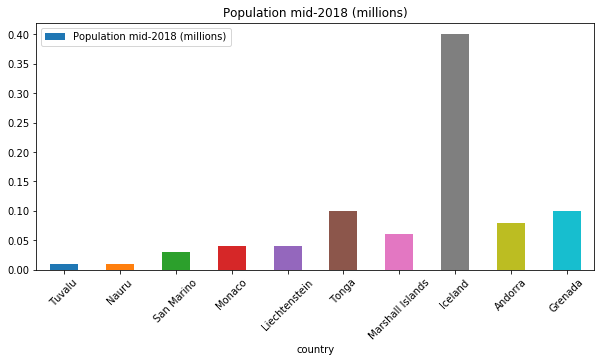

In [50]:
top_10_art_per_pop.plot.bar(x='country', y='articles-per-population-percentage', rot=45, subplots=True, layout=(2,1), figsize=(10,10))
top_10_art_per_pop.plot.bar(x='country', y='Population mid-2018 (millions)', rot=45, subplots=True, layout=(2,1), figsize=(10,10))
plt.show()

### Table 2: Bottom 10 countries by coverage: 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population

In [51]:
bottom_10_art_per_pop = articles_population.tail(10)

In [52]:
bottom_10_art_per_pop

,country,Population mid-2018 (millions),articles-per-population-percentage
340,Bangladesh,166.4,0.000192
439,Mozambique,30.5,0.000190
530,Thailand,66.2,0.000169
12505,Zambia,17.7,0.000141
2234,"Korea, North",25.6,0.000141
287,Ethiopia,107.5,0.000094
1168,Uzbekistan,32.9,0.000085
38,China,1393.8,0.000081
139,Indonesia,265.2,0.000079
10,India,1371.3,0.000071


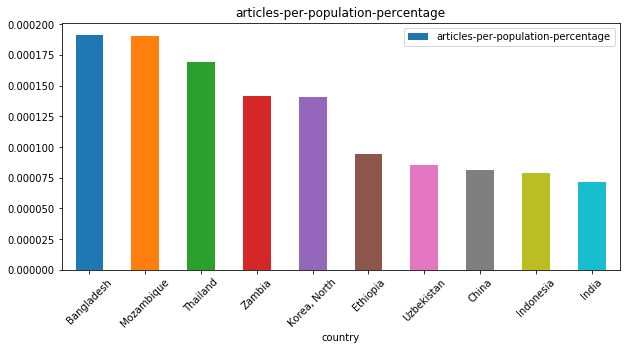

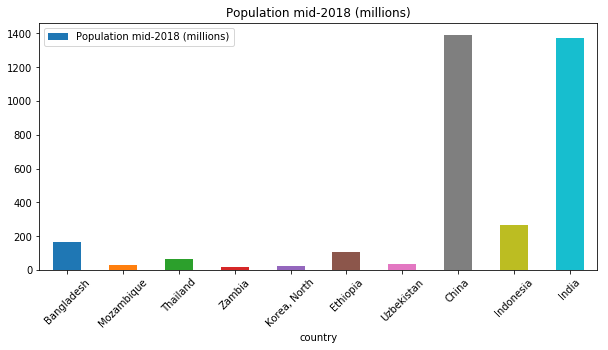

In [53]:
bottom_10_art_per_pop.plot.bar(x='country', y='articles-per-population-percentage', rot=45, subplots=True, layout=(2,1), figsize=(10,10))
bottom_10_art_per_pop.plot.bar(x='country', y='Population mid-2018 (millions)', rot=45, subplots=True, layout=(2,1), figsize=(10,10))
plt.show()

### Table 3: Top 10 countries by relative quality: 10 highest-ranked countries in terms of the relative proportion of politician articles that are of GA and FA-quality

In [54]:
top_10_high_quality = GA_FA_data.head(10)

In [55]:
top_10_high_quality

,country,Population mid-2018 (millions),high-quality-percentage
20143,"Korea, North",25.60,19.444444
32509,Saudi Arabia,33.40,12.711864
22589,Mauritania,4.50,12.500000
7144,Central African Republic,4.70,12.121212
31185,Romania,19.50,11.370262
37883,Tuvalu,0.01,9.259259
4696,Bhutan,0.80,9.090909
9937,Dominica,0.07,8.333333
36259,Syria,18.30,7.812500
4605,Benin,11.50,7.692308


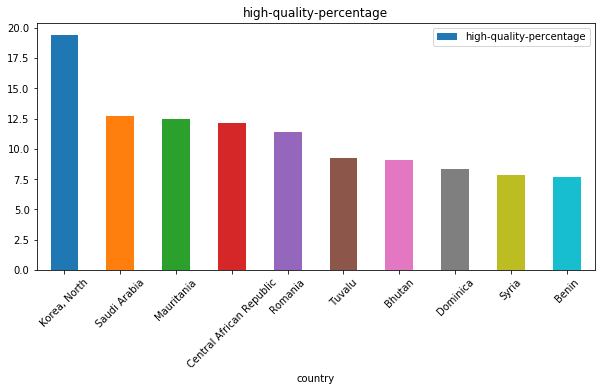

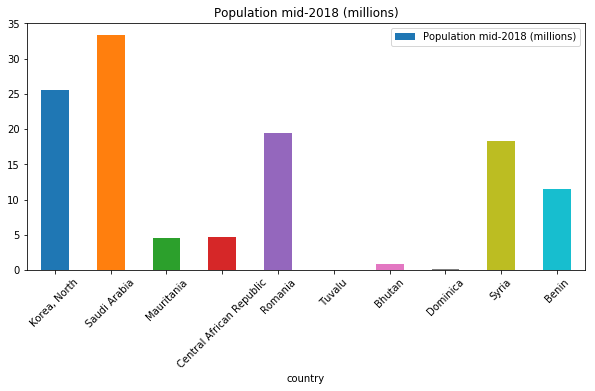

In [56]:
top_10_high_quality.plot.bar(x='country', y='high-quality-percentage', rot=45, subplots=True, layout=(2,1), figsize=(10,10))
top_10_high_quality.plot.bar(x='country', y='Population mid-2018 (millions)', rot=45, subplots=True, layout=(2,1), figsize=(10,10))
plt.show()

### Table 4: Bottom 10 countries by relative quality: 10 lowest-ranked countries in terms of the relative proportion of politician articles that are of GA and FA-quality

In [57]:
bottom_10_high_quality = GA_FA_data.tail(10)

In [58]:
bottom_10_high_quality

,country,Population mid-2018 (millions),high-quality-percentage
3473,Azerbaijan,9.9,0.558659
10562,Fiji,0.9,0.507614
21225,Lithuania,2.8,0.409836
8785,Colombia,49.8,0.350877
26415,Nigeria,195.9,0.295421
29185,Peru,32.2,0.285714
24385,Nepal,29.7,0.280112
35857,Switzerland,8.5,0.248756
36925,Tanzania,59.1,0.246914
4085,Belgium,11.4,0.192308


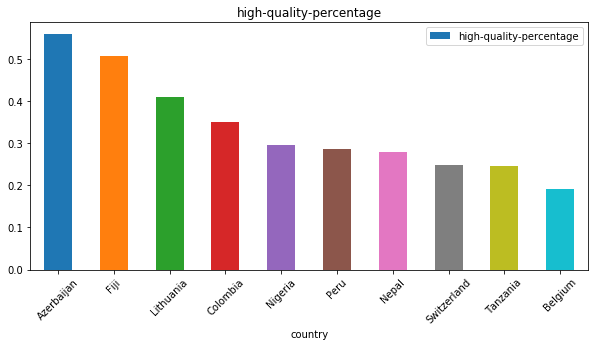

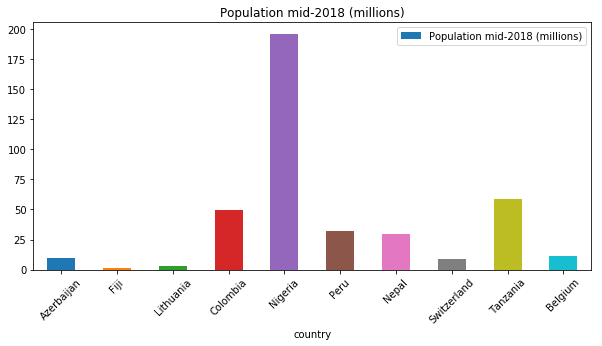

In [59]:
bottom_10_high_quality.plot.bar(x='country', y='high-quality-percentage', rot=45, subplots=True, layout=(2,1), figsize=(10,10))
bottom_10_high_quality.plot.bar(x='country', y='Population mid-2018 (millions)', rot=45, subplots=True, layout=(2,1), figsize=(10,10))
plt.show()

### Table 5: Geographic regions by coverage: Ranking of geographic regions (in descending order) in terms of the total count of politician articles from countries in each region as a proportion of total regional population

In [60]:
regional_top_art_pop = Geographic_Region.drop(["high-quality-percentage"], 1)
regional_top_art_pop.sort_values('articles-per-population-percentage', ascending=False)

,country,Population mid-2018 (millions),articles-per-population-percentage
189,OCEANIA,41.0,0.007629
144,EUROPE,746.0,0.002127
59,LATIN AMERICA AND THE CARIBBEAN,649.0,0.000796
0,AFRICA,1284.0,0.000534
56,NORTHERN AMERICA,365.0,0.000526
95,ASIA,4536.0,0.000254


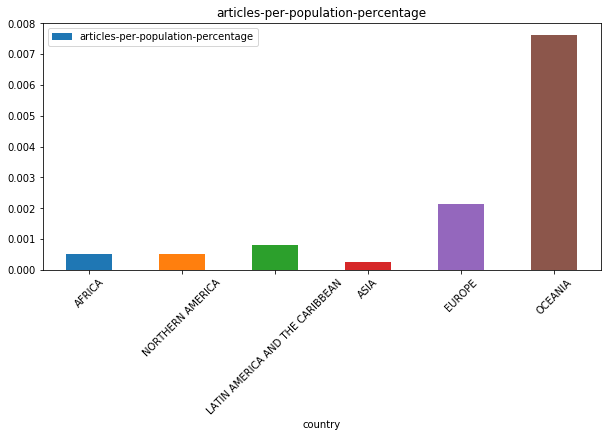

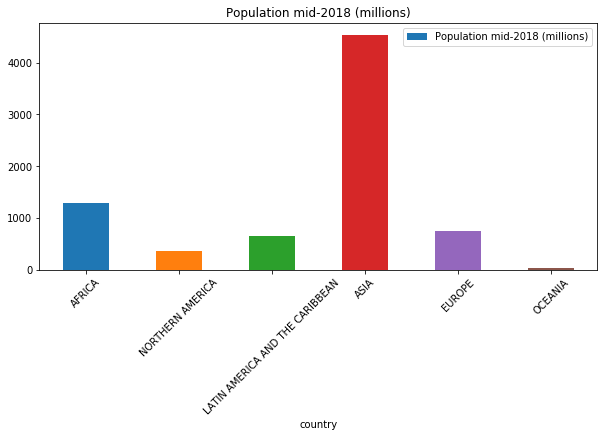

In [61]:
regional_top_art_pop.plot.bar(x='country', y='articles-per-population-percentage', rot=45, subplots=True, layout=(2,1), figsize=(10,10))
regional_top_art_pop.plot.bar(x='country', y='Population mid-2018 (millions)', rot=45, subplots=True, layout=(2,1), figsize=(10,10))
plt.show()

### Table 6: Geographic regions by coverage: Ranking of geographic regions (in descending order) in terms of the relative proportion of politician articles from countries in each region that are of GA and FA-quality

In [63]:
regional_high_quality = Geographic_Region.drop(["articles-per-population-percentage"], 1)
regional_high_quality.sort_values('high-quality-percentage', ascending=False)

,country,Population mid-2018 (millions),high-quality-percentage
56,NORTHERN AMERICA,365.0,0.268275
189,OCEANIA,41.0,0.067454
0,AFRICA,1284.0,0.026632
59,LATIN AMERICA AND THE CARIBBEAN,649.0,0.025825
95,ASIA,4536.0,0.023315
144,EUROPE,746.0,0.012795


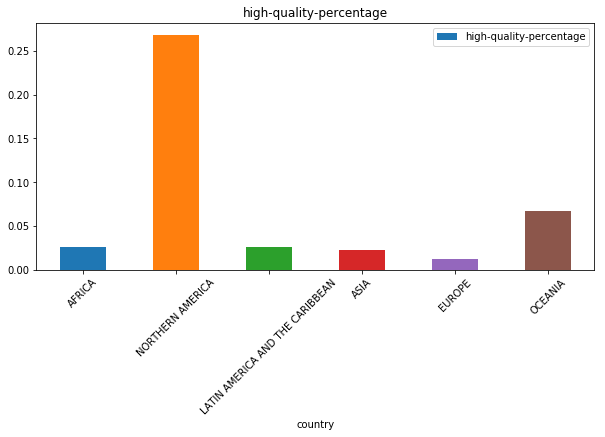

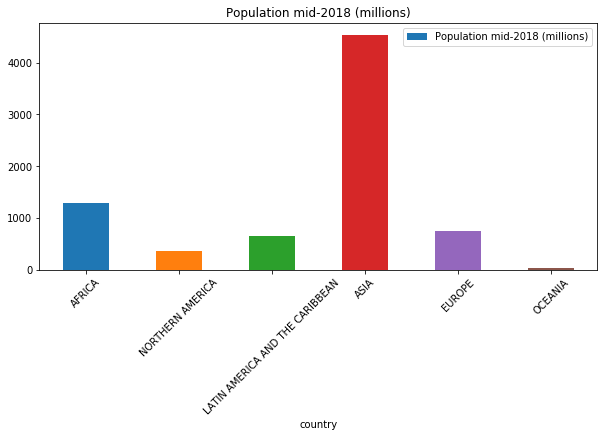

In [64]:
regional_high_quality.plot.bar(x='country', y='high-quality-percentage', rot=45, subplots=True, layout=(2,1), figsize=(10,10))
regional_high_quality.plot.bar(x='country', y='Population mid-2018 (millions)', rot=45, subplots=True, layout=(2,1), figsize=(10,10))
plt.show()